Strain Rate: 0.0001
RD Params: [-4.12125142e-01  1.11932194e+00  3.17183747e+02  7.41428863e-01
  6.94679060e+01 -1.88987311e-02  1.88745499e-01]
DD Params: [ 2.37650128e+02  2.30829935e+01  1.35731609e+02 -2.46159851e+02
  1.41806353e+02 -1.68471132e-02  4.87604177e-01]
TD Params: [ 7.89972212e+01  9.43888617e+00  1.26726212e+02 -8.21362555e+01
  1.32646588e+02 -1.65552422e-02  4.86531139e-01]


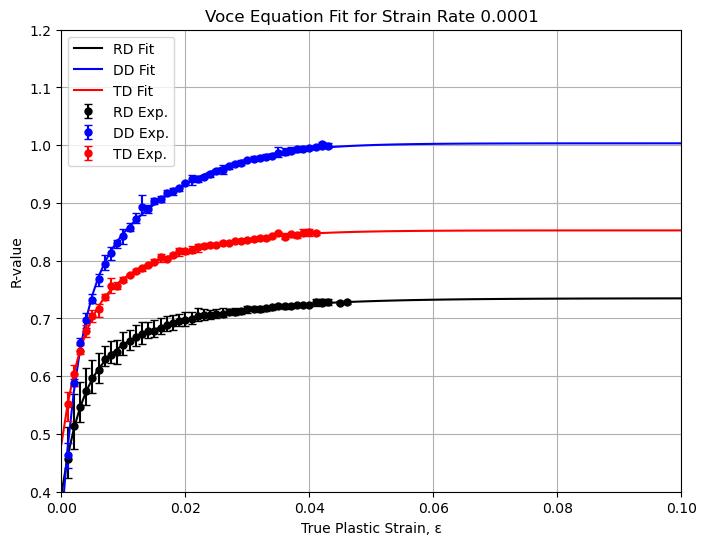

In [18]:
import numpy as np
import pandas as pd
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# Define the equation for r-value evolution
def r_value_eq(ε, c1, c2, C3, C4, C5, C6, alpha):
    term1 = alpha * (c1 + c2 * (1 - np.exp(-C3 * np.clip(ε, 0, 1e2))))
    term2 = (1 - alpha) * (C4 / (1 + np.exp(-C5 * (np.clip(ε, 0, 1e2) - C6))))
    return term1 + term2

# Define the residuals function
def residuals(params, strain, r_values):
    return r_value_eq(strain, *params) - r_values

# Load the data
file_path = 'Exp_rV_StrRtDpn(Tmp298.csv'  
data = pd.read_csv(file_path)

# Function to process data for the strain rate 0.0001
def process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col):
    # Extract data for a specific strain rate
    strain = data[strain_col]
    rd_r_value = data[rd_col]
    dd_r_value = data[dd_col]
    td_r_value = data[td_col]
    
    rd_upper_error = data[rd_u_col]  # Upper error bar for RD
    rd_lower_error = data[rd_l_col]  # Lower error bar for RD
    
    dd_upper_error = data[dd_u_col]  # Upper error bar for DD
    dd_lower_error = data[dd_l_col]  # Lower error bar for DD
    
    td_upper_error = data[td_u_col]  # Upper error bar for TD
    td_lower_error = data[td_l_col]  # Lower error bar for TD

    # Check for NaN or inf values and filter them
    valid_idx_rd = np.isfinite(strain) & np.isfinite(rd_r_value)
    valid_idx_dd = np.isfinite(strain) & np.isfinite(dd_r_value)
    valid_idx_td = np.isfinite(strain) & np.isfinite(td_r_value)

    strain_rd = strain[valid_idx_rd]
    rd_r_value_clean = rd_r_value[valid_idx_rd]
    rd_error_upper_clean = rd_upper_error[valid_idx_rd]
    rd_error_lower_clean = rd_lower_error[valid_idx_rd]

    strain_dd = strain[valid_idx_dd]
    dd_r_value_clean = dd_r_value[valid_idx_dd]
    dd_error_upper_clean = dd_upper_error[valid_idx_dd]
    dd_error_lower_clean = dd_lower_error[valid_idx_dd]

    strain_td = strain[valid_idx_td]
    td_r_value_clean = td_r_value[valid_idx_td]
    td_error_upper_clean = td_upper_error[valid_idx_td]
    td_error_lower_clean = td_lower_error[valid_idx_td]
    
    # Define specific initial guesses for the strain rate 0.0001
    initial_guess = [0.8, 0.1, 20, 0.5, 10, 0.02, 0.5]

    # Use least_squares to perform fitting
    res_rd = least_squares(residuals, initial_guess, args=(strain_rd, rd_r_value_clean))
    res_dd = least_squares(residuals, initial_guess, args=(strain_dd, dd_r_value_clean))
    res_td = least_squares(residuals, initial_guess, args=(strain_td, td_r_value_clean))

    # Generate fitted r-values for the strain range up to 3
    strain_fit = np.linspace(0, 3, 3001)
    rd_r_fit = r_value_eq(strain_fit, *res_rd.x)
    dd_r_fit = r_value_eq(strain_fit, *res_dd.x)
    td_r_fit = r_value_eq(strain_fit, *res_td.x)

    # Plot the experimental data with error bars and fitted curves
    plt.figure(figsize=(8, 6))
    
    # Plot RD data with error bars
    plt.errorbar(strain_rd, rd_r_value_clean, 
                 yerr=[rd_error_lower_clean, rd_error_upper_clean], 
                 fmt='o', color='black', label='RD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, rd_r_fit, color='black', label='RD Fit')

    # Plot DD data with error bars
    plt.errorbar(strain_dd, dd_r_value_clean, 
                 yerr=[dd_error_lower_clean, dd_error_upper_clean], 
                 fmt='o', color='blue', label='DD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, dd_r_fit, color='blue', label='DD Fit')

    # Plot TD data with error bars
    plt.errorbar(strain_td, td_r_value_clean, 
                 yerr=[td_error_lower_clean, td_error_upper_clean], 
                 fmt='o', color='red', label='TD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, td_r_fit, color='red', label='TD Fit')

    # Customize the plot
    plt.xlabel('True Plastic Strain, ε')
    plt.ylabel('R-value')
    plt.title(f'Voce Equation Fit for Strain Rate {strain_rate_label}')
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 0.1])  # Adjust the x-axis limits as needed
    plt.ylim([0.4, 1.2])  # Adjust the y-axis limits as needed
    plt.savefig(f'Voce_Equation_Fit_{strain_rate_label}.png', dpi=300)

    # Prepare data for CSV export
    export_data = pd.DataFrame({
        'Strain': strain_fit,
        'RD_R_value': rd_r_fit,
        'DD_R_value': dd_r_fit,
        'TD_R_value': td_r_fit
    })
    
    # Export to CSV
    export_data.to_csv(f'R_values_StrainRate_{strain_rate_label}.csv', index=False)

    # Return the final parameters for RD, DD, TD
    return res_rd.x, res_dd.x, res_td.x

# Define strain rate info for 0.0001
strain_rate_info_0001 = (
    '0.0001', 
    'Tmp298.15K_StrRt0.0001_RD_E', 
    'Tmp298.15K_StrRt0.0001_RD_r', 
    'Tmp298.15K_StrRt0.0001_DD_r', 
    'Tmp298.15K_StrRt0.0001_TD_r',
    'Tmp298.15K_StrRt0.0001_RD_U', 
    'Tmp298.15K_StrRt0.0001_RD_L', 
    'Tmp298.15K_StrRt0.0001_DD_U', 
    'Tmp298.15K_StrRt0.0001_DD_L', 
    'Tmp298.15K_StrRt0.0001_TD_U', 
    'Tmp298.15K_StrRt0.0001_TD_L'
)

# Process the strain rate 0.0001
rd_params, dd_params, td_params = process_strain_rate(*strain_rate_info_0001)

# Print the fitted parameters
print(f"Strain Rate: {strain_rate_info_0001[0]}")
print(f"RD Params: {rd_params}")
print(f"DD Params: {dd_params}")
print(f"TD Params: {td_params}")


Strain Rate: 0.001
RD Params: [8.20829573e-01 3.22948206e-01 5.00000000e+01 6.67336579e-01
 7.22553292e-14 2.77667171e-04 5.64750881e-01]
DD Params: [ 1.          0.9999969   3.4796375   0.99999158 29.99752677  0.05964034
  0.97240836]
TD Params: [ 1.          0.99982417  1.06736003  1.         29.99999995  0.05944933
  0.71631807]

Strain Rate: 0.01
RD Params: [6.96832746e-01 5.34224121e-01 5.00000000e+01 5.74514392e-01
 1.11230427e-09 9.94987342e-01 5.85601384e-01]
DD Params: [1.00000000e+00 2.93245126e-02 5.00000000e+01 1.00000000e+00
 1.64570533e+01 4.90839832e-11 1.00000000e+00]
TD Params: [1.00000000e+00 2.28010787e-03 5.00000000e+01 7.67066385e-01
 1.22936363e-03 1.01185333e-07 1.00000000e+00]

Strain Rate: 0.1
RD Params: [9.10114722e-01 4.24417261e-20 4.91134121e+01 8.84652684e-01
 5.34594567e-14 9.48648705e-01 6.40014458e-01]
DD Params: [1.00000000e+00 1.29840513e-01 4.99999992e+01 9.99999604e-01
 1.30113507e-03 5.33826660e-11 1.00000000e+00]
TD Params: [1.00000000e+00 2.19672

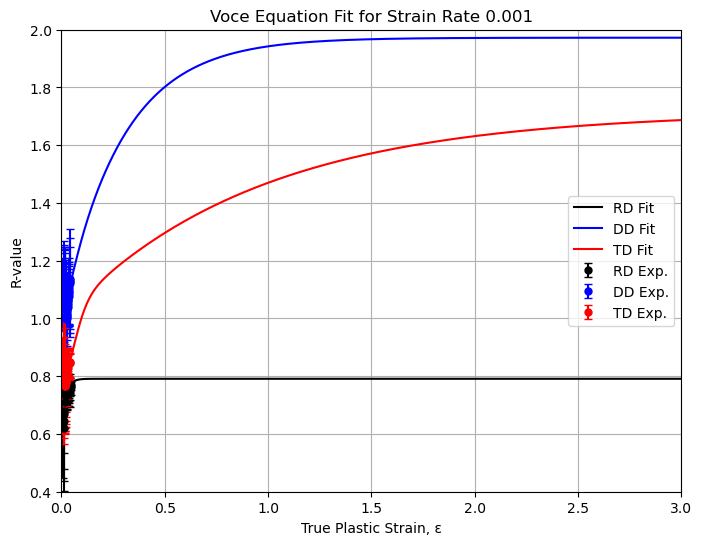

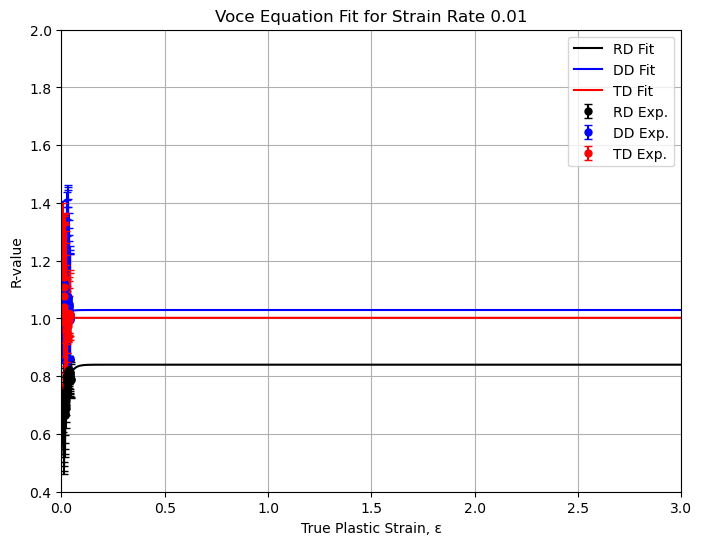

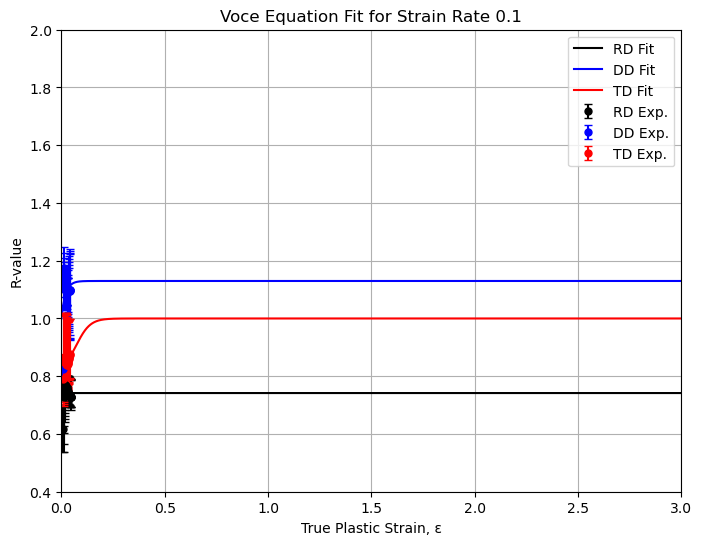

In [25]:
# Define the residuals function
#def residuals(params, strain, r_values):
#   return r_value_eq(strain, *params) - r_values
def residuals(params, strain, r_values, penalty_weight=100.0):
    r_fit = r_value_eq(strain, *params)
    residuals = r_fit - r_values
    penalty = penalty_weight * (r_fit[-1] - r_values[-1])**2  # penalty term for constant R-value at high strains
    return np.concatenate((residuals, [penalty]))

# Function to process data for each strain rate
def process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col):
    # Extract data for a specific strain rate
    strain = data[strain_col].values
    rd_r_value = data[rd_col].values
    dd_r_value = data[dd_col].values
    td_r_value = data[td_col].values
    
    rd_upper_error = data[rd_u_col].values  # Upper error bar for RD
    rd_lower_error = data[rd_l_col].values  # Lower error bar for RD
    
    dd_upper_error = data[dd_u_col].values  # Upper error bar for DD
    dd_lower_error = data[dd_l_col].values  # Lower error bar for DD
    
    td_upper_error = data[td_u_col].values  # Upper error bar for TD
    td_lower_error = data[td_l_col].values  # Lower error bar for TD

    # Check for NaN or inf values and filter them
    valid_idx_rd = np.isfinite(strain) & np.isfinite(rd_r_value)
    valid_idx_dd = np.isfinite(strain) & np.isfinite(dd_r_value)
    valid_idx_td = np.isfinite(strain) & np.isfinite(td_r_value)

    strain_rd = strain[valid_idx_rd]
    rd_r_value_clean = rd_r_value[valid_idx_rd]
    rd_error_upper_clean = rd_upper_error[valid_idx_rd]
    rd_error_lower_clean = rd_lower_error[valid_idx_rd]

    strain_dd = strain[valid_idx_dd]
    dd_r_value_clean = dd_r_value[valid_idx_dd]
    dd_error_upper_clean = dd_upper_error[valid_idx_dd]
    dd_error_lower_clean = dd_lower_error[valid_idx_dd]

    strain_td = strain[valid_idx_td]
    td_r_value_clean = td_r_value[valid_idx_td]
    td_error_upper_clean = td_upper_error[valid_idx_td]
    td_error_lower_clean = td_lower_error[valid_idx_td]
    
    # Define specific initial guesses for each strain rate
    initial_guesses = {
        '0.001': [0.75, 0.35, 20, 0.60, 10, 0.020, 0.5],
        '0.01': [0.65, 0.25, 18, 0.55, 13, 0.025, 0.4],
        '0.1': [0.55, 0.45, 32, 0.90, 7, 0.010, 0.3]
    }

    # Get initial guesses for the parameters
    initial_guess = initial_guesses.get(strain_rate_label, [0.5] * 7)

    # Set bounds for the parameters
    bounds = (
        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],  # Lower bounds
        [1.0, 1.0, 50.0, 1.0, 30.0, 1.0, 1.0]  # Upper bounds
    )

    # Attempt to fit the data
    res_rd = least_squares(residuals, initial_guess, args=(strain_rd, rd_r_value_clean), bounds=bounds)
    res_dd = least_squares(residuals, initial_guess, args=(strain_dd, dd_r_value_clean), bounds=bounds)
    res_td = least_squares(residuals, initial_guess, args=(strain_td, td_r_value_clean), bounds=bounds)

    # Generate fitted r-values for the strain range up to 3
    strain_fit = np.linspace(0, 3, 3001)
    rd_r_fit = r_value_eq(strain_fit, *res_rd.x)
    dd_r_fit = r_value_eq(strain_fit, *res_dd.x)
    td_r_fit = r_value_eq(strain_fit, *res_td.x)

    # Plot the experimental data with error bars and fitted curves
    plt.figure(figsize=(8, 6))
    
    # Plot RD data with error bars
    plt.errorbar(strain_rd, rd_r_value_clean, 
                 yerr=[rd_error_lower_clean, rd_error_upper_clean], 
                 fmt='o', color='black', label='RD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, rd_r_fit, color='black', label='RD Fit')

    # Plot DD data with error bars
    plt.errorbar(strain_dd, dd_r_value_clean, 
                 yerr=[dd_error_lower_clean, dd_error_upper_clean], 
                 fmt='o', color='blue', label='DD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, dd_r_fit, color='blue', label='DD Fit')

    # Plot TD data with error bars
    plt.errorbar(strain_td, td_r_value_clean, 
                 yerr=[td_error_lower_clean, td_error_upper_clean], 
                 fmt='o', color='red', label='TD Exp.', markersize=5, capsize=3)
    plt.plot(strain_fit, td_r_fit, color='red', label='TD Fit')

    # Customize the plot
    plt.xlabel('True Plastic Strain, ε')
    plt.ylabel('R-value')
    plt.title(f'Voce Equation Fit for Strain Rate {strain_rate_label}')
    plt.legend()
    plt.grid(True)
    plt.xlim([0, 3])  # Adjusting the x-axis limits
    plt.ylim([0.4, 2])  # Adjusting the y-axis limits
    plt.savefig(f'Voce_Equation_Fit_{strain_rate_label}.png', dpi=300)
    
    # Prepare data for CSV export
    export_data = pd.DataFrame({
        'Strain': strain_fit,
        'RD_R_value': rd_r_fit,
        'DD_R_value': dd_r_fit,
        'TD_R_value': td_r_fit
    })
    
    # Export to CSV
    export_data.to_csv(f'R_values_StrainRate_{strain_rate_label}.csv', index=False)
    
    # Return the final parameters for RD, DD, TD
    return res_rd.x, res_dd.x, res_td.x

# Process each strain rate
strain_rate_info = [
    ('0.001', 'Tmp298.15K_StrRt0.001_RD_E', 'Tmp298.15K_StrRt0.001_RD_r', 'Tmp298.15K_StrRt0.001_DD_r', 'Tmp298.15K_StrRt0.001_TD_r',
     'Tmp298.15K_StrRt0.001_RD_U', 'Tmp298.15K_StrRt0.001_RD_L', 'Tmp298.15K_StrRt0.001_DD_U', 'Tmp298.15K_StrRt0.001_DD_L', 'Tmp298.15K_StrRt0.001_TD_U', 'Tmp298.15K_StrRt0.001_TD_L'),
    ('0.01', 'Tmp298.15K_StrRt0.01_RD_E', 'Tmp298.15K_StrRt0.01_RD_r', 'Tmp298.15K_StrRt0.01_DD_r', 'Tmp298.15K_StrRt0.01_TD_r',
     'Tmp298.15K_StrRt0.01_RD_U', 'Tmp298.15K_StrRt0.01_RD_L', 'Tmp298.15K_StrRt0.01_DD_U', 'Tmp298.15K_StrRt0.01_DD_L', 'Tmp298.15K_StrRt0.01_TD_U', 'Tmp298.15K_StrRt0.01_TD_L'),
    ('0.1', 'Tmp298.15K_StrRt0.1_RD_E', 'Tmp298.15K_StrRt0.1_RD_r', 'Tmp298.15K_StrRt0.1_DD_r', 'Tmp298.15K_StrRt0.1_TD_r',
     'Tmp298.15K_StrRt0.1_RD_U', 'Tmp298.15K_StrRt0.1_RD_L', 'Tmp298.15K_StrRt0.1_DD_U', 'Tmp298.15K_StrRt0.1_DD_L', 'Tmp298.15K_StrRt0.1_TD_U', 'Tmp298.15K_StrRt0.1_TD_L')
]

# Loop through strain rates and print fitted parameters
for strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col in strain_rate_info:
    rd_params, dd_params, td_params = process_strain_rate(strain_rate_label, strain_col, rd_col, dd_col, td_col, rd_u_col, rd_l_col, dd_u_col, dd_l_col, td_u_col, td_l_col)
    
    # Check if parameters are returned successfully
    if rd_params is not None and dd_params is not None and td_params is not None:
        print(f"Strain Rate: {strain_rate_label}")
        print(f"RD Params: {rd_params}")
        print(f"DD Params: {dd_params}")
        print(f"TD Params: {td_params}\n")
    else:
        print(f"Failed to fit parameters for strain rate {strain_rate_label}.\n")
